In [16]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import convert, coalesce
import networkx as nx
import matplotlib.pyplot as plt

In [17]:
# Number of nodes in original graph
NUM_NODES = 10

In [18]:
def generate_bipartite_graphs(hypergraph_order: int):
    source_nodes = torch.tensor([])
    destination_nodes = torch.tensor([])

    # Generate "hypergraph_order" perfect matchings
    for i in range(hypergraph_order):
        left_nodes = torch.tensor([j for j in range(NUM_NODES)])
        right_nodes = torch.tensor([NUM_NODES + j for j in range(NUM_NODES)])
        left_perm = torch.randperm(left_nodes.shape[0])
        right_perm = torch.randperm(right_nodes.shape[0])
        source_nodes = torch.concat((source_nodes, left_nodes[left_perm]))
        destination_nodes = torch.concat((destination_nodes, right_nodes[right_perm]))

    expander_edge_index = torch.cat([source_nodes[None, ...], destination_nodes[None, ...]], dim=0)
    expander_edge_index = coalesce(expander_edge_index)
    return expander_edge_index

In [19]:
edge_index = generate_bipartite_graphs(3)

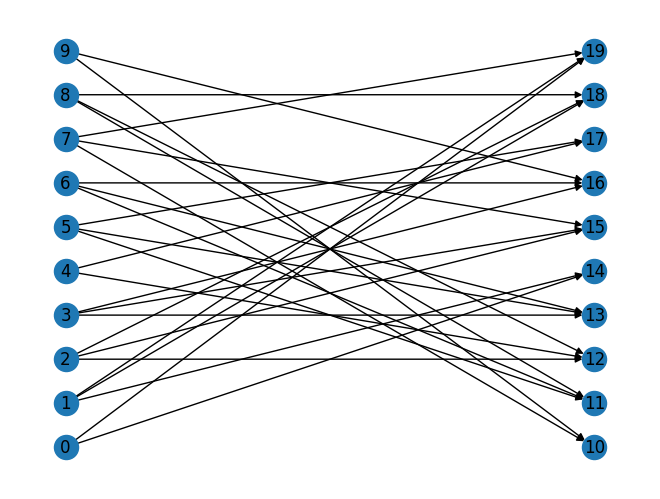

In [20]:
data = Data(edge_index=edge_index, num_nodes=NUM_NODES * 2)
nx_graph = convert.to_networkx(data)
pos = nx.bipartite_layout(nx_graph, [i for i in range(NUM_NODES)])
nx.draw(nx_graph, pos=pos, with_labels=True)